In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
file = 'sched_window_analysis2.csv'
file_df = pd.read_csv(file)

file_df["Earliest Start datetime"] = ""
file_df["Due Date datetime"] = ""
file_df["Scheduling Window"] = ""


In [3]:
# convert Earliest Start and Due Date to datetime values
file_df["Earliest Start datetime"] = pd.to_datetime(file_df["SA: Earliest Start Permitted"],format="%m/%d/%Y %I:%M %p")
file_df["Due Date datetime"] = pd.to_datetime(file_df["SA: Due Date"],format="%m/%d/%Y %I:%M %p")
file_df["Scheduling Window"] = (file_df["Due Date datetime"]-file_df["Earliest Start datetime"])
file_df["Scheduling Window"] = file_df["Scheduling Window"].apply(lambda val: (val.total_seconds()/3600))

# get the Onsite SAs
onsite_df = file_df[file_df["SA: Type"]=="Onsite Visit"]

# get total number of onsite SAs
total_onsite = len(onsite_df["SA: Type"])

# get the SAs that went to the Scheduling Engine
onsite_df = onsite_df.loc[(onsite_df["SA: Schedule Exception Reason"] != "No Service Territory")& \
(onsite_df["SA: Schedule Exception Reason"] != "Invalid \"No Skill\" Skill Requirement on the Work Order.")& \
(onsite_df["SA: Schedule Exception Reason"] != "Parts are not available by the Due Date.") & \
(onsite_df["SA: Schedule Exception Reason"] != "Due Date is in the past.")]
num_onsite_sent_to_engine = len(onsite_df["SA: Type"])

# get the SAs that went straight to Sched Exception
sched_excep_df = file_df.loc[((file_df["SA: Schedule Exception Reason"] == "No Service Territory")| \
(file_df["SA: Schedule Exception Reason"] == "Invalid \"No Skill\" Skill Requirement on the Work Order.")| \
(file_df["SA: Schedule Exception Reason"] == "Parts are not available by the Due Date.") | \
(file_df["SA: Schedule Exception Reason"] == "Due Date is in the past.")) & (file_df["SA: Type"]=="Onsite Visit")]

# count the number of SAs that went straight to Sched Exception
num_sched_excep = len(sched_excep_df["SA: Type"])


# Scheduling Overview

,Total Onsite SAs (Jan-June '19'),Number sent to Scheduling Engine,Number gone immediately to Schedule Exception,Number initially scheduled,Number truly auto-scheduled,Number where no Service Resource found,Percent sent to Scheduling Engine,Percent immediately to Schedule Exception,Percent initially scheduled,Percent no Service Resource found
0,2247,1052,1195,372,32,680,46.82%,53.18%,35.36%,64.64%


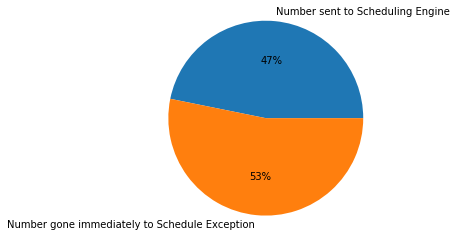

In [38]:
# create a DataFrame and pie chart to show the proportion of qualified and dis-qualified Service Appointments

sa_summary_table = pd.DataFrame({"Total Onsite SAs (Jan-June '19')": total_onsite,
                                 "Number sent to Scheduling Engine": num_onsite_sent_to_engine,
                                 "Number gone immediately to Schedule Exception": num_sched_excep,
                                 "Number initially scheduled": num_scheduled,
                                 "Number truly auto-scheduled":num_auto_sched,
                                 "Number where no Service Resource found": num_no_ssrs_found,
                                 "Percent sent to Scheduling Engine": "{:.2%}".format(num_onsite_sent_to_engine/total_onsite),
                                 "Percent immediately to Schedule Exception": "{:.2%}".format(num_sched_excep/total_onsite),
                                 "Percent initially scheduled": "{:.2%}".format((num_scheduled/num_onsite_sent_to_engine)),
                                 "Percent no Service Resource found": "{:.2%}".format((num_no_ssrs_found/num_onsite_sent_to_engine))},index=[0])

labels = ["Number sent to Scheduling Engine","Number gone immediately to Schedule Exception"]
sizes = [num_onsite_sent_to_engine,num_sched_excep]
plt.pie(sizes,labels=labels,autopct='%1.0f%%')
plt.axis('equal')
sa_summary_table

In [39]:
# group the SAs that went to the Scheduling Engine by the size of the Scheduling Window

window_bins = [0,2,4,6,8,10,12,100]
group_names = ["<2 hrs", "2-4 hrs", "4-6 hrs", "6-8 hrs", "8-10 hrs", "10-12 hrs", "12+ hrs"]
onsite_df["Scheduling Window Size"] = pd.cut(file_df["Scheduling Window"], window_bins, labels = group_names)

# All Valid SAs Scheduling Window Size

In [37]:
onsite_grouped_df = onsite_df.groupby(["Scheduling Window Size"])
onsite_grouped_df["Scheduling Window Size"].count()

Scheduling Window Size
<2 hrs       101
2-4 hrs      185
4-6 hrs       69
6-8 hrs       71
8-10 hrs      61
10-12 hrs     13
12+ hrs      479
Name: Scheduling Window Size, dtype: int64

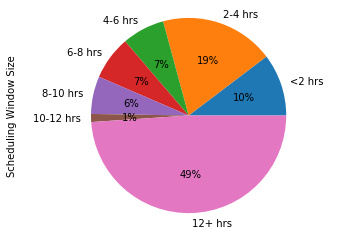

In [41]:
# show all SAs by Scheduling Window size

onsite_grouped_df["Scheduling Window Size"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# SAs that were scheduled

In [42]:
# show only Service Appointments that were sent to the scheduling engine by Scheduling Window Size

scheduled_df = onsite_df.loc[(file_df["SA: Schedule Exception Reason"] != "No SSRs were found.")]
num_scheduled = len(scheduled_df)
scheduled_grouped_df = scheduled_df.groupby(["Scheduling Window Size"])
scheduled_grouped_df["Scheduling Window Size"].count()

Scheduling Window Size
<2 hrs        22
2-4 hrs       60
4-6 hrs       21
6-8 hrs       34
8-10 hrs      31
10-12 hrs      7
12+ hrs      182
Name: Scheduling Window Size, dtype: int64

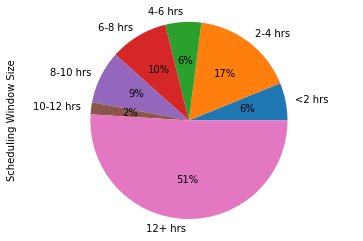

In [10]:
scheduled_grouped_df["Scheduling Window Size"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# No SSRs found

In [43]:
# Service Appointments that were sent to the scheduling engine but not auto-scheduled by Scheduling Window Size

no_ssrs_found_df = onsite_df.loc[(file_df["SA: Schedule Exception Reason"] == "No SSRs were found.")]
num_no_ssrs_found = len(no_ssrs_found_df)
no_ssrs_grouped_df = no_ssrs_found_df.groupby(["Scheduling Window Size"])
no_ssrs_grouped_df["Scheduling Window Size"].count()

Scheduling Window Size
<2 hrs        79
2-4 hrs      125
4-6 hrs       48
6-8 hrs       37
8-10 hrs      30
10-12 hrs      6
12+ hrs      297
Name: Scheduling Window Size, dtype: int64

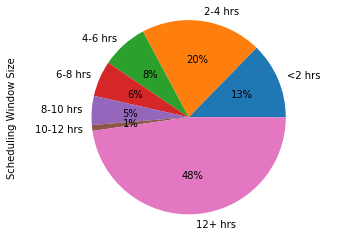

In [12]:
no_ssrs_grouped_df["Scheduling Window Size"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# AEDT SAs Scheduling Window Size

In [13]:
aedt_df = onsite_df.loc[(file_df["SA: Service Territory"] == "AU - ACT")|(file_df["SA: Service Territory"]=="AU - NSW")| \
                        (file_df["SA: Service Territory"] == "AU - Tasmania")|(file_df["SA: Service Territory"] == "AU - VIC")]
aedt_df_grouped = aedt_df.groupby(["Scheduling Window Size"])
aedt_df_grouped['Scheduling Window'].count()


Scheduling Window Size
<2 hrs        74
2-4 hrs      137
4-6 hrs       60
6-8 hrs       44
8-10 hrs      42
10-12 hrs     11
12+ hrs      350
Name: Scheduling Window, dtype: int64

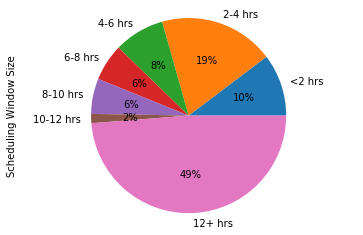

In [14]:
aedt_df_grouped["Scheduling Window Size"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# Schedule Exception Reasons

In [44]:
# identify most common reasons for Service Appointments not to be scheduled.

sched_excep_grouped = sched_excep_df.groupby(["SA: Schedule Exception Reason"])
sched_excep_grouped["SA: Schedule Exception Reason"].count()

SA: Schedule Exception Reason
Due Date is in the past.                                    34
Invalid "No Skill" Skill Requirement on the Work Order.    260
No Service Territory                                        44
Parts are not available by the Due Date.                   857
Name: SA: Schedule Exception Reason, dtype: int64

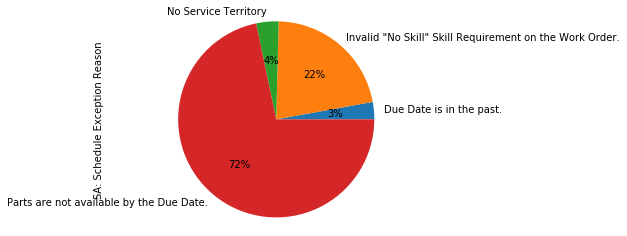

In [16]:
sched_excep_grouped["SA: Schedule Exception Reason"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# Autoscheduled SAs

In [17]:
auto_sched_df = file_df[file_df["SA: Schedule Mode"]=="Automatic"]
num_auto_sched = len(auto_sched_df)


# SAs sent to Sched Engine by Service Obligation

In [47]:
# Service Appointments that made it to the scheduling engine by service obligation

scheduled_by_oblig = onsite_df.groupby(["Service Obligation"]).count()
scheduled_by_oblig["Work Order Number"]

Service Obligation
Committed    263
External     566
Internal     223
Name: Work Order Number, dtype: int64

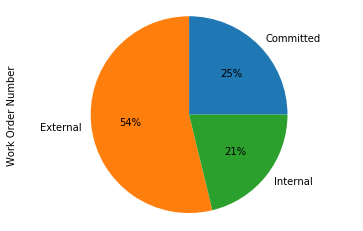

In [19]:
scheduled_by_oblig["Work Order Number"].plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# SAs gone immediately to Sched Exception by Service Obligation

In [46]:
# Service Appointments in Schedule Exception by service obligation

not_scheduled_by_oblig = sched_excep_df.groupby(["Service Obligation"]).count()
not_scheduled_by_oblig["Work Order Number"]

Service Obligation
Committed    105
External     919
Internal     171
Name: Work Order Number, dtype: int64

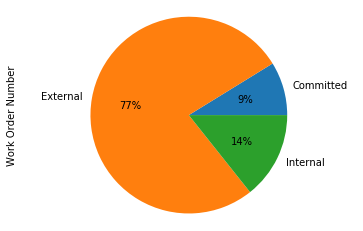

In [21]:
not_scheduled_by_oblig["Work Order Number"].plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()